# Objective:
Leverage Python and SQL to analyze the E-commerce dataset "Exploring-Ecommerce-database-and-Implementing-Data-Mining". Your task is to extract insights from the data, focusing on customer behavior, product performance, and sales trends.

# Simplified ERD Diagram

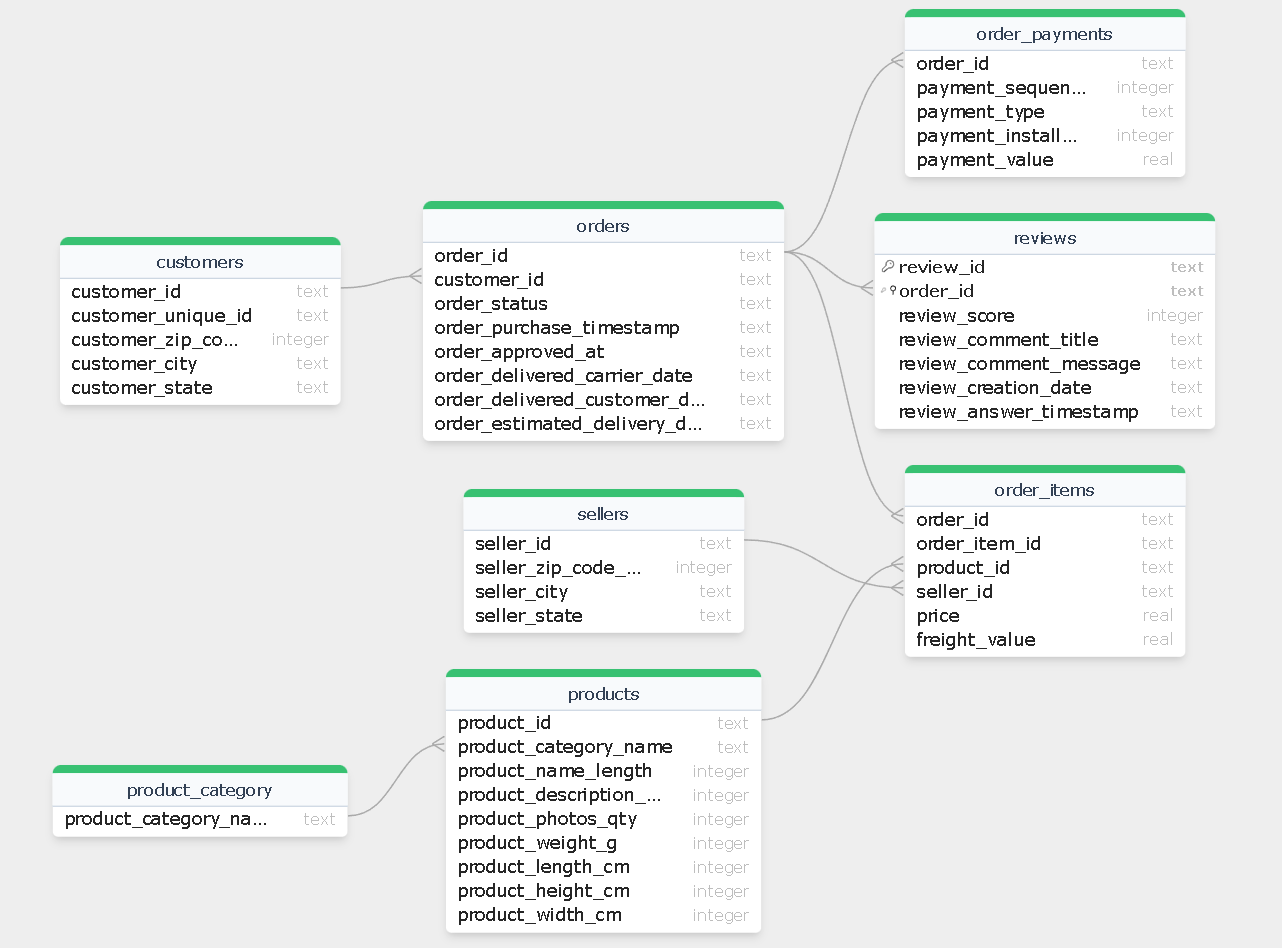

# Clone the dataset Github repo

In [47]:
!git clone https://github.com/mudit-parmar/Exploring-Ecommerce-database-and-Implementing-Data-Mining

fatal: destination path 'Exploring-Ecommerce-database-and-Implementing-Data-Mining' already exists and is not an empty directory.


# Create the tables and foreign keys

In [48]:
import sqlite3

# Connect to SQLite database
conn = sqlite3.connect('debi.db')

# Create a cursor object
cursor = conn.cursor()

# Dropping tables if they exist to avoid errors
cursor.execute("DROP TABLE IF EXISTS order_payments")
cursor.execute("DROP TABLE IF EXISTS order_items")
cursor.execute("DROP TABLE IF EXISTS reviews")
cursor.execute("DROP TABLE IF EXISTS orders")
cursor.execute("DROP TABLE IF EXISTS customers")
cursor.execute("DROP TABLE IF EXISTS products")
cursor.execute("DROP TABLE IF EXISTS sellers")
cursor.execute("DROP TABLE IF EXISTS product_category")

# Creating tables
cursor.execute("""
CREATE TABLE customers (
    customer_id TEXT NOT NULL PRIMARY KEY,
    customer_unique_id TEXT,
    customer_zip_code INTEGER,
    customer_city TEXT,
    customer_state TEXT
)
""")

cursor.execute("""
CREATE TABLE product_category (
    product_category_name TEXT NOT NULL PRIMARY KEY
)
""")

cursor.execute("""
CREATE TABLE products (
    product_id TEXT NOT NULL PRIMARY KEY,
    product_category_name TEXT,
    product_name_length INTEGER,
    product_description_length INTEGER,
    product_photos_qty INTEGER,
    product_weight_g INTEGER,
    product_length_cm INTEGER,
    product_height_cm INTEGER,
    product_width_cm INTEGER,
    FOREIGN KEY (product_category_name) REFERENCES product_category(product_category_name)
)
""")

cursor.execute("""
CREATE TABLE sellers (
    seller_id TEXT NOT NULL PRIMARY KEY,
    seller_zip_code_prefix INTEGER,
    seller_city TEXT,
    seller_state TEXT CHECK (LENGTH(seller_state) <=2)
)
""")

cursor.execute("""
CREATE TABLE orders (
    order_id TEXT PRIMARY KEY,
    customer_id TEXT,
    order_status TEXT,
    order_purchase_timestamp TEXT,
    order_approved_at TEXT,
    order_delivered_carrier_date TEXT,
    order_delivered_customer_date TEXT,
    order_estimated_delivery_date TEXT,
    CHECK (order_status IN ('delivered', 'shipped', 'processing')),
    FOREIGN KEY (customer_id) REFERENCES customers(customer_id)
)
""")

cursor.execute("""
CREATE TABLE reviews (
    review_id TEXT NOT NULL,
    order_id TEXT NOT NULL,
    review_score INTEGER,
    review_comment_title TEXT,
    review_comment_message TEXT,
    review_creation_date TEXT,
    review_answer_timestamp TEXT,
    PRIMARY KEY (review_id, order_id),
    CHECK (review_score>0 AND review_score<=5),
    FOREIGN KEY (order_id) REFERENCES orders(order_id)
)
""")

cursor.execute("""
CREATE TABLE order_items (
    order_id TEXT NOT NULL,
    order_item_id TEXT,
    product_id TEXT,
    seller_id TEXT,
    price REAL CHECK(price >= 0),
    freight_value REAL CHECK(freight_value >= 0),
    FOREIGN KEY (order_id) REFERENCES orders(order_id),
    FOREIGN KEY (product_id) REFERENCES products(product_id),
    FOREIGN KEY (seller_id) REFERENCES sellers(seller_id)
)
""")

cursor.execute("""
CREATE TABLE order_payments (
    order_id TEXT,
    payment_sequential INTEGER,
    payment_type TEXT,
    payment_installments INTEGER,
    payment_value REAL CHECK(payment_value >= 0),
    FOREIGN KEY (order_id) REFERENCES orders(order_id)
)
""")

# Committing the transactions
conn.commit()

# Closing the connection
conn.close()


# Fill the tables

In [49]:
import csv

# Connect to SQLite database
conn = sqlite3.connect('debi.db')
cursor = conn.cursor()

# Create a temporary combined table to hold CSV data if it doesn't exist
cursor.execute("DROP TABLE IF EXISTS combined")
cursor.execute('''
CREATE TABLE IF NOT EXISTS combined (
    product_id TEXT,
    seller_id TEXT,
    order_id TEXT,
    customer_id TEXT,
    order_status TEXT,
    order_purchase_timestamp TEXT,
    order_approved_at TEXT,
    order_delivered_carrier_date TEXT,
    order_delivered_customer_date TEXT,
    order_estimated_delivery_date TEXT,
    customer_unique_id TEXT,
    customer_zip_code INTEGER,
    customer_city TEXT,
    customer_state TEXT,
    review_id TEXT,
    review_score INTEGER,
    review_comment_title TEXT,
    review_comment_message TEXT,
    review_creation_date TEXT,
    review_answer_timestamp TEXT,
    payment_sequential INTEGER,
    payment_type TEXT,
    payment_installments INTEGER,
    payment_value REAL,
    order_item_id TEXT,
    price REAL,
    freight_value REAL,
    seller_zip_code_prefix INTEGER,
    seller_city TEXT,
    seller_state TEXT,
    product_category_name TEXT,
    product_name_length INTEGER,
    product_description_length INTEGER,
    product_photos_qty INTEGER,
    product_weight_g INTEGER,
    product_length_cm INTEGER,
    product_height_cm INTEGER,
    product_width_cm INTEGER
)''')

# Load data from CSV into the temporary table
with open('/content/Exploring-Ecommerce-database-and-Implementing-Data-Mining/Orders_merged.csv', 'r', encoding='utf-8') as file:
    csv_reader = csv.reader(file)
    next(csv_reader)  # Skip header row
    for row in csv_reader:
        cursor.execute('''
        INSERT INTO combined VALUES (?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?);
        ''', row)

# Insert data into structured tables
cursor.execute('INSERT INTO customers SELECT DISTINCT customer_id, customer_unique_id, customer_zip_code, customer_city, customer_state FROM combined WHERE customer_id IS NOT NULL')
cursor.execute('INSERT INTO product_category SELECT DISTINCT product_category_name FROM combined WHERE product_category_name IS NOT NULL')
cursor.execute('INSERT INTO products SELECT DISTINCT product_id, product_category_name, product_name_length, product_description_length, product_photos_qty, product_weight_g, product_length_cm, product_height_cm, product_width_cm FROM combined WHERE product_id IS NOT NULL')
cursor.execute('INSERT INTO orders SELECT DISTINCT order_id, customer_id, order_status, order_purchase_timestamp, order_approved_at, order_delivered_carrier_date, order_delivered_customer_date, order_estimated_delivery_date FROM combined WHERE order_id IS NOT NULL')
cursor.execute('INSERT INTO sellers SELECT DISTINCT seller_id, seller_zip_code_prefix, seller_city, seller_state FROM combined WHERE seller_id IS NOT NULL')
cursor.execute('INSERT INTO order_payments SELECT DISTINCT order_id, payment_sequential, payment_type, payment_installments, payment_value FROM combined WHERE order_id IS NOT NULL')
cursor.execute('INSERT INTO order_items SELECT DISTINCT order_id, order_item_id, product_id, seller_id, price, freight_value FROM combined WHERE order_id IS NOT NULL')
cursor.execute('INSERT INTO reviews SELECT DISTINCT review_id, order_id, review_score, review_comment_title, review_comment_message, review_creation_date, review_answer_timestamp FROM combined WHERE review_id IS NOT NULL')

# Commit changes and close the connection
conn.commit()
conn.close()

# Test that the database was created succesfully

In [50]:
def print_top_rows(table_name):
    # Connect to SQLite database
    conn = sqlite3.connect('debi.db')
    cursor = conn.cursor()
    # Create SQL query string
    query = f"SELECT * FROM {table_name} LIMIT 10"

    # Execute the query
    cursor.execute(query)

    # Fetch the top 10 rows
    rows = cursor.fetchall()

    # Print the rows
    print(f"Top 10 rows from {table_name}:")
    for row in rows:
        print(row)

    # Close the connection
    conn.close()

# Use the function to print the top 10 rows from three tables

print_top_rows('customers')
print("----")
print_top_rows('products')
print("----")
print_top_rows('orders')
print("----")
print_top_rows('product_category')

Top 10 rows from customers:
('86c180c33f454b35e1596a99da3dddc4', 'cd929c5ecff5fc60e9d808d33702e434', 95890, 'teutonia', 'RS')
('68f2b37558e27791155db34bcded5ac0', 'cbbeff6b693e69511cf9d059f4b71036', 14403, 'franca', 'SP')
('6cd217b674e22cf568f6a2cf6060fd07', 'f51fb63558e88eb3373773d106fa6880', 2883, 'sao paulo', 'SP')
('8517e7c86998bf39a540087da6f115d9', '7f2dfd48dba158dbf61ba2ea631d93df', 93530, 'novo hamburgo', 'RS')
('82b838f513e00463174cc7cae7e76c1f', '4e32da06df703a2561f63e75b13f6260', 95174, 'farroupilha', 'RS')
('8cefa3f70ed73678ae31bd3ebf441aff', '44d7152dc796f40ba57f074837515d91', 4843, 'sao paulo', 'SP')
('74b30896d931057ed18fd8e404ec5b9f', '23775069a10e6814ab83bf3133979f76', 97010, 'santa maria', 'RS')
('f1375b843314f00de278b414ac4c958a', 'ef523a490d0b4b30d3218016362ff984', 7133, 'guarulhos', 'SP')
('9ee410cee2322bd96ad9ed1949a48333', '5a7b42836d728d8ef64dc853bc3eb9eb', 5508, 'sao paulo', 'SP')
('e5bcb726405d10a80aaa80e36b66e50d', 'e890c412a8b910d4709660658d700483', 75830, '

# Example Visualizations:
Before diving into the assignment requirements, let's create a couple of example visualizations to understand the dataset better.

## Example 1: Total Sales Over Time

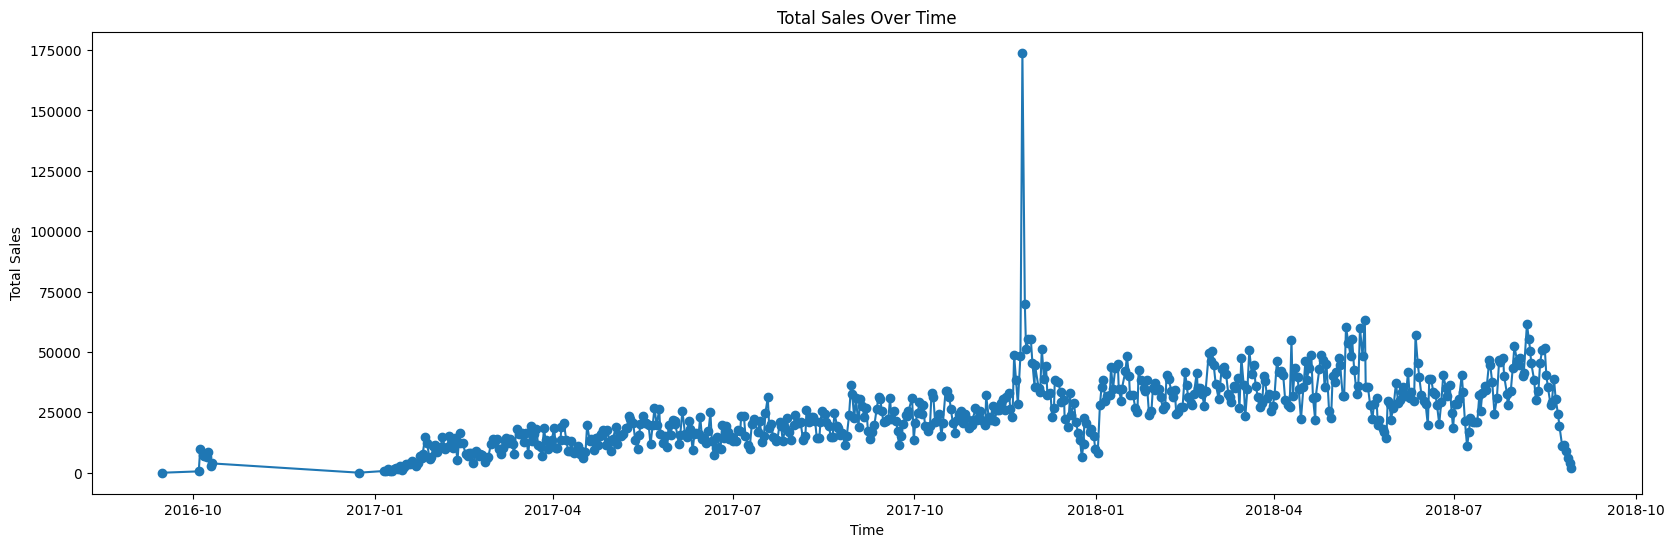

In [51]:
import pandas as pd
import matplotlib.pyplot as plt

conn = sqlite3.connect('debi.db')

query = '''
SELECT order_purchase_timestamp, SUM(payment_value) as total_sales
FROM orders
JOIN order_payments ON orders.order_id = order_payments.order_id
GROUP BY strftime('%Y-%m-%d', order_purchase_timestamp)
ORDER BY order_purchase_timestamp;
'''

df_sales_over_time = pd.read_sql_query(query, conn)
df_sales_over_time['order_purchase_timestamp'] = pd.to_datetime(df_sales_over_time['order_purchase_timestamp'])
plt.figure(figsize=(20, 6))
plt.plot(df_sales_over_time['order_purchase_timestamp'], df_sales_over_time['total_sales'], marker='o', linestyle='-')
plt.title('Total Sales Over Time')
plt.xlabel('Time')
plt.ylabel('Total Sales')
plt.show()

conn.close()

## Example 2: Product Categories Distribution

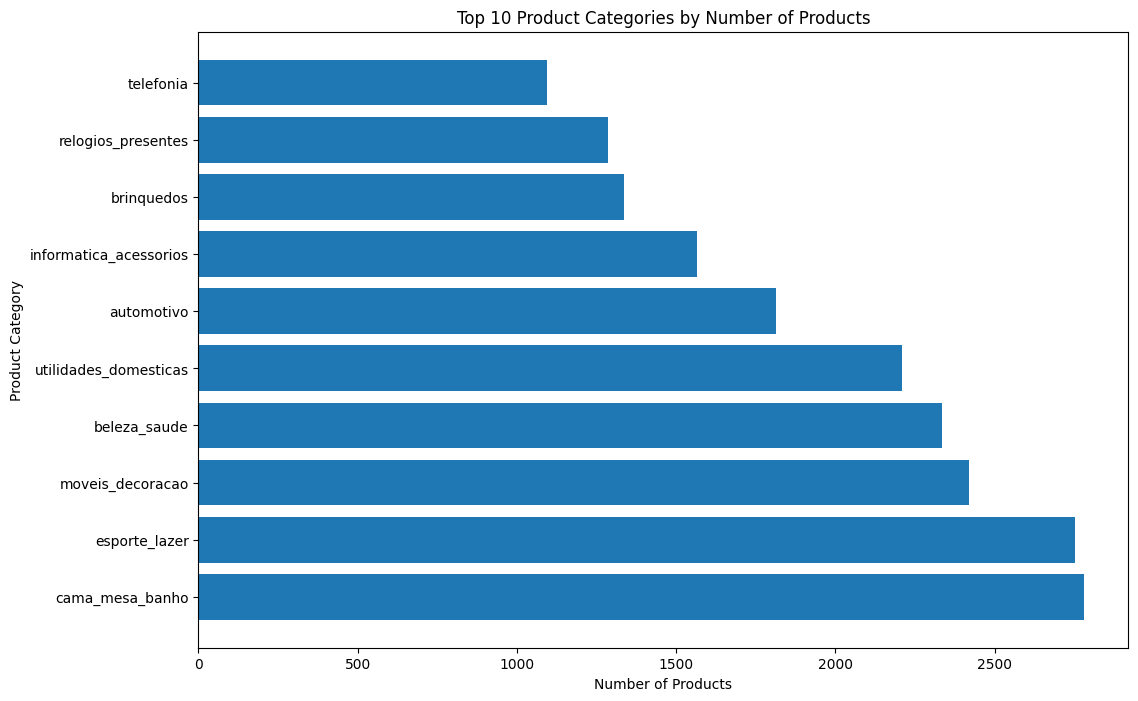

In [52]:
conn = sqlite3.connect('debi.db')

query = '''
SELECT product_category_name, COUNT(product_id) as product_count
FROM products
GROUP BY product_category_name
ORDER BY product_count DESC
LIMIT 10;
'''

df_product_distribution = pd.read_sql_query(query, conn)
plt.figure(figsize=(12, 8))
plt.barh(df_product_distribution['product_category_name'], df_product_distribution['product_count'])
plt.title('Top 10 Product Categories by Number of Products')
plt.xlabel('Number of Products')
plt.ylabel('Product Category')
plt.show()

conn.close()

# **Assignment Requirements:**

## 1) Product Performance Analysis:
- Identify the top 10 best-selling products.
- Visualization: Generate a bar chart showing the top 10 products and their sales.

In [54]:
# Connect to the database
conn = sqlite3.connect('debi.db')

# Execute the query
query = """
SELECT p.product_id, p.product_category_name, SUM(oi.price) AS total_sales
FROM products p
JOIN order_items oi ON p.product_id = oi.product_id
GROUP BY p.product_id, p.product_category_name
ORDER BY total_sales DESC
LIMIT 10;
"""
df = pd.read_sql_query(query, conn)

# Close the connection
conn.close()

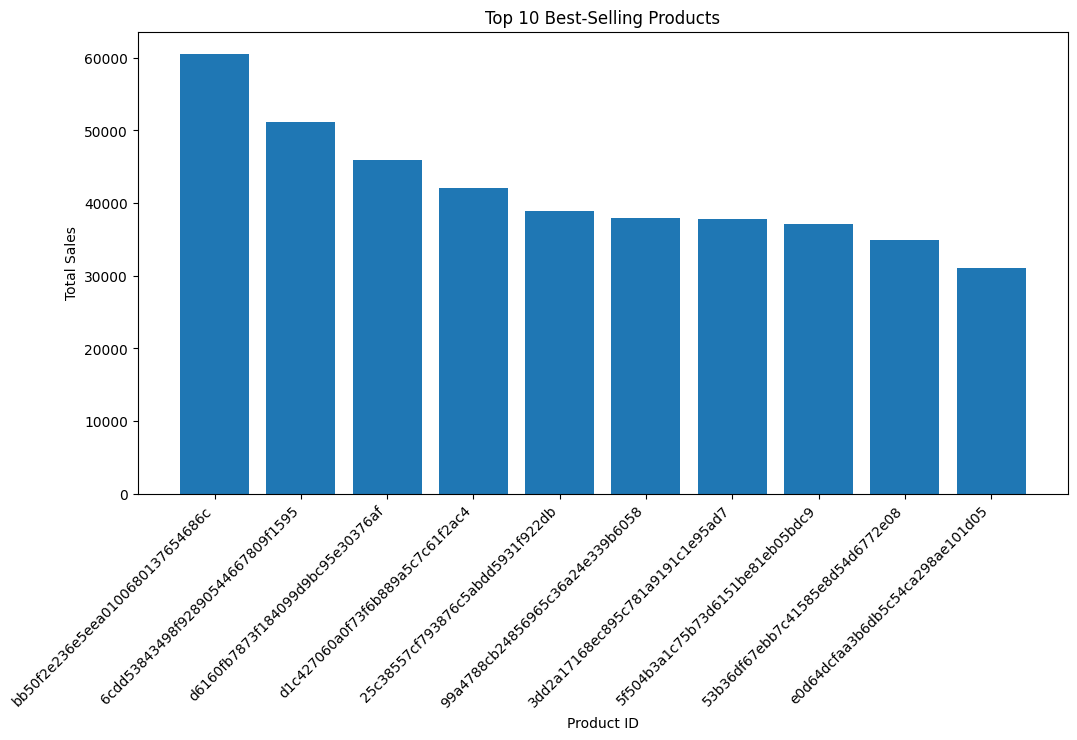

In [55]:
# Create a bar chart
plt.figure(figsize=(12, 6))
plt.bar(df['product_id'], df['total_sales'])
plt.xlabel('Product ID')
plt.ylabel('Total Sales')
plt.title('Top 10 Best-Selling Products')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.show()

## 2) Order Status Analysis:

- Analyze the distribution of order statuses (e.g., delivered, shipped, canceled).
- Visualization: Create a pie chart showing the proportion of each order status.

In [56]:
# Connect to the database
conn = sqlite3.connect('debi.db')

# Execute the query
query = """
SELECT order_status, COUNT(*) AS order_count
FROM orders
GROUP BY order_status;
"""
df = pd.read_sql_query(query, conn)

# Close the connection
conn.close()

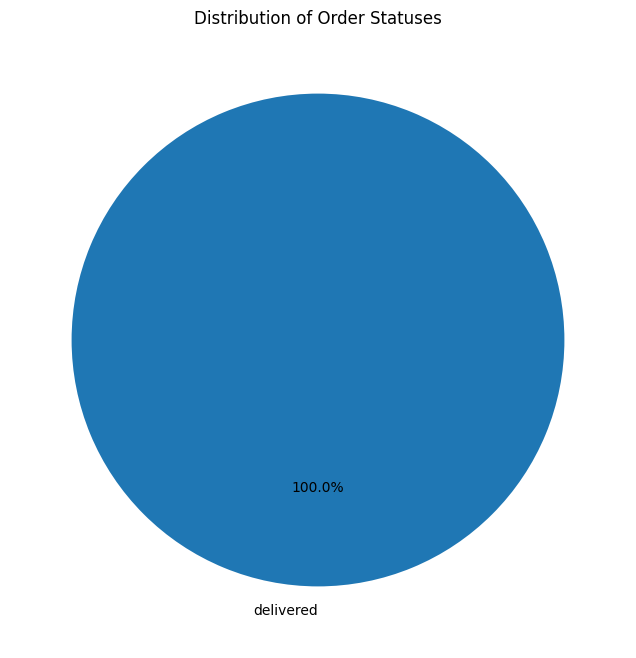

In [57]:
# Create a pie chart
plt.figure(figsize=(8, 8))
plt.pie(df['order_count'], labels=df['order_status'], autopct='%1.1f%%', startangle=90)
plt.title('Distribution of Order Statuses')
plt.show()

## 3) Customer Segmentation:

- Segment customers based on their purchasing patterns. Are there distinct groups that emerge?
- Visualization: Create a scatter plot visualizing the segments.
- Tip: Use clustering techniques like K-Means on features such as purchase frequency, average spend, and product categories bought.

In [58]:
from sklearn.cluster import KMeans

In [59]:
# Connect to the database
conn = sqlite3.connect('debi.db')

# SQL query to extract relevant customer data
query = """
SELECT c.customer_unique_id,
       COUNT(DISTINCT o.order_id) AS purchase_frequency,
       AVG(oi.price) AS average_spend
FROM customers c
JOIN orders o ON c.customer_id = o.customer_id
JOIN order_items oi ON o.order_id = oi.order_id
GROUP BY c.customer_unique_id;
"""

# Execute query and load into DataFrame
customer_data = pd.read_sql_query(query, conn)

# Close the connection
conn.close()

# Prepare data for clustering
X = customer_data[['purchase_frequency', 'average_spend']]

In [60]:
# Apply K-Means clustering
kmeans = KMeans(n_clusters=3, random_state=0)  # Assuming 3 clusters, adjust as needed
customer_data['cluster'] = kmeans.fit_predict(X)

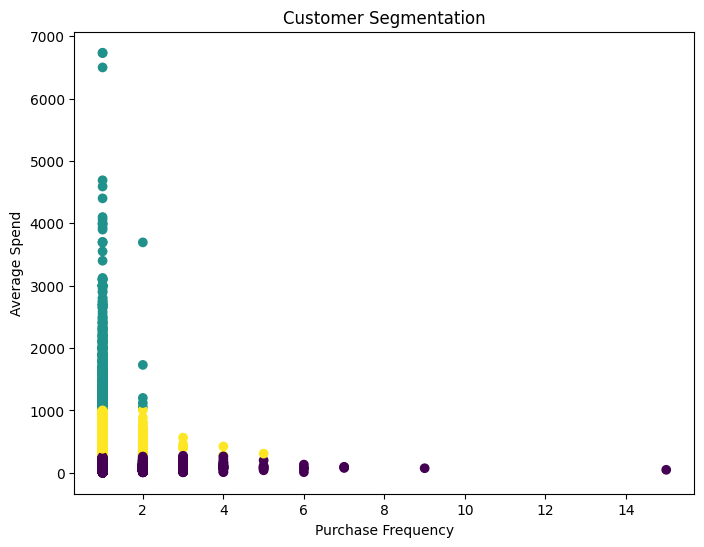

In [61]:
# Visualize the segments using a scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(customer_data['purchase_frequency'], customer_data['average_spend'], c=customer_data['cluster'])
plt.xlabel('Purchase Frequency')
plt.ylabel('Average Spend')
plt.title('Customer Segmentation')
plt.show()

4) Review Score Impact:

- Investigate the relationship between review scores and product sales.
- Visualization: Create a line plot or scatter plot showing review scores against sales.

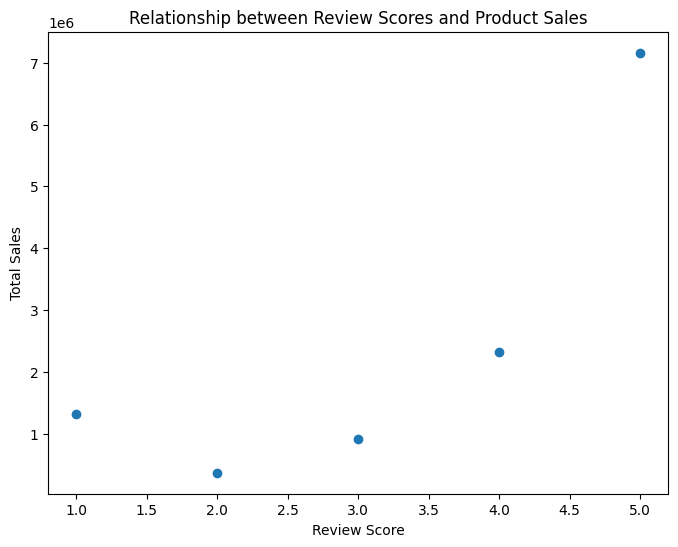

In [62]:
# Import necessary libraries
import sqlite3  # For interacting with the SQLite database
import pandas as pd  # For data manipulation and analysis
import matplotlib.pyplot as plt  # For creating visualizations

# Connect to the SQLite database
conn = sqlite3.connect('debi.db')

# SQL query to extract review scores and product sales
query = """
SELECT r.review_score, SUM(oi.price) AS total_sales
FROM reviews r
JOIN orders o ON r.order_id = o.order_id
JOIN order_items oi ON o.order_id = oi.order_id
GROUP BY r.review_score;
"""

# Execute the query and load into a pandas DataFrame
review_sales_data = pd.read_sql_query(query, conn)

# Close the database connection
conn.close()

# Create a scatter plot to visualize the relationship
plt.figure(figsize=(8, 6))  # Set figure size
plt.scatter(review_sales_data['review_score'], review_sales_data['total_sales'])  # Create scatter plot
plt.xlabel('Review Score')  # Set x-axis label
plt.ylabel('Total Sales')  # Set y-axis label
plt.title('Relationship between Review Scores and Product Sales')  # Set plot title
plt.show()  # Display the plot

## 5) Geographic Sales Distribution:

- Analyze sales distribution across different states or cities.
- Visualization: Create a heatmap or geographical plot showing sales distribution.

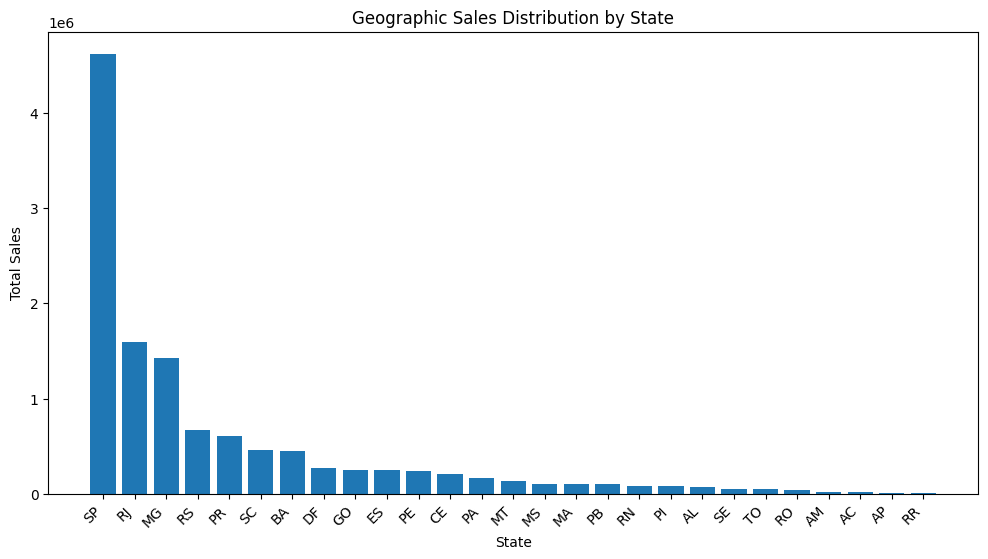

In [63]:
# Import necessary libraries
import sqlite3  # For interacting with the SQLite database
import pandas as pd  # For data manipulation and analysis
import matplotlib.pyplot as plt  # For creating visualizations

# Connect to the SQLite database
conn = sqlite3.connect('debi.db')

# SQL query to extract sales data by state
query = """
SELECT c.customer_state, SUM(oi.price) AS total_sales
FROM customers c
JOIN orders o ON c.customer_id = o.customer_id
JOIN order_items oi ON o.order_id = oi.order_id
GROUP BY c.customer_state
ORDER BY total_sales DESC;
"""

# Execute the query and load into a pandas DataFrame
sales_by_state = pd.read_sql_query(query, conn)

# Close the database connection
conn.close()

# Create a bar chart to visualize sales distribution
plt.figure(figsize=(12, 6))  # Set figure size
plt.bar(sales_by_state['customer_state'], sales_by_state['total_sales'])  # Create bar chart
plt.xlabel('State')  # Set x-axis label
plt.ylabel('Total Sales')  # Set y-axis label
plt.title('Geographic Sales Distribution by State')  # Set plot title
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.show()  # Display the plot

## 6) Time Series Analysis:

- Explore how sales have changed over time on a monthly basis.
- Visualization: Create a time series plot showing trends in monthly sales.

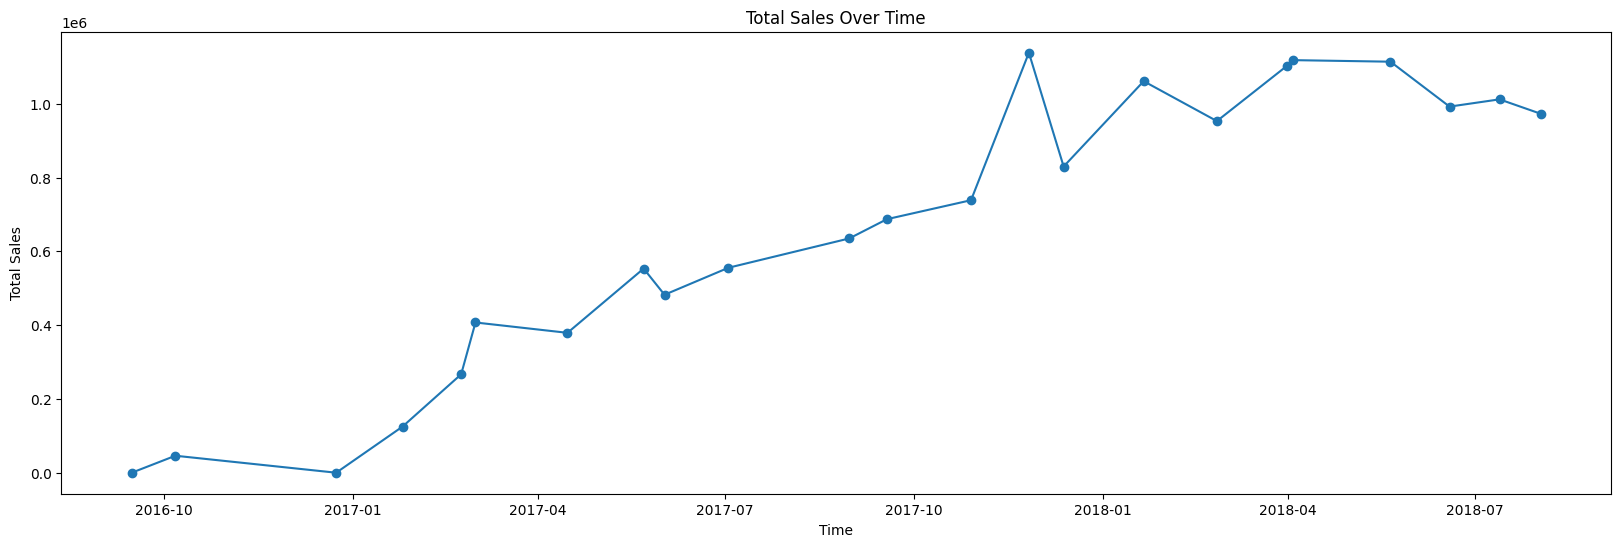

In [71]:

conn = sqlite3.connect('debi.db')

query = '''
SELECT order_purchase_timestamp, SUM(payment_value) as total_sales
FROM orders
JOIN order_payments ON orders.order_id = order_payments.order_id
GROUP BY strftime('%Y-%m', order_purchase_timestamp)
ORDER BY order_purchase_timestamp;
'''

df_sales_over_time = pd.read_sql_query(query, conn)
df_sales_over_time['order_purchase_timestamp'] = pd.to_datetime(df_sales_over_time['order_purchase_timestamp'])
plt.figure(figsize=(20, 6))
plt.plot(df_sales_over_time['order_purchase_timestamp'], df_sales_over_time['total_sales'], marker='o', linestyle='-')
plt.title('Total Sales Over Time')
plt.xlabel('Time')
plt.ylabel('Total Sales')
plt.show()

conn.close()

# **Delivery:**
- Jupyter notebook containing code for all above requirements.
- Power Point presentation (10 slides max) showing the following:
-- Showcase the tools and libraries used (e.g., Scikit-learn, Pandas) and visualizations produced during the analysis.
-- Summarize key findings and conclusions drawn from the data analysis, particularly focusing on customer segmentation and product performance.




# **Data Analysis Assignment Presentation Example Outline**

## Slide 1: Title Slide

## Slide 2: ML Tools and Libraries Used, for example:
- Pandas for data manipulation and analysis
- Scikit-learn for machine learning tasks
- Matplotlib and Seaborn for data visualization
- Machine Learning algorithms used:
-- Tsne for visualization
-- K-means
-- PCA for dimensionality reduction
-- etc...

## Slides 3: Dataset Overview
- Describe the source and structure of the e-commerce dataset.
- Include a small visualization, like a dataset schema or a few rows of the dataset to give a concrete idea.
- Mention the key variables that will be analyzed.

## Slide 4: Initial EDA (Exploratory Data Analysis) Findings
- Present a couple of initial findings from exploratory data analysis.
- Use simple visualizations like histograms for the distribution of key variables or a heatmap for correlations.
- Briefly mention any surprising insights or patterns discovered.

### Slide 5: Methodology and Segmentation
- Description of the clustering method used (e.g., K-Means)
- Criteria for segmentation (e.g., purchase frequency, average spend)

### Slide 6: Segmentation Results
- Visualizations illustrating customer segments
- Characteristics of each segment

## Slides 7-8: Product Performance Analysis
### Slide 7: Analysis Criteria
- Metrics used to evaluate product performance (e.g., sales volume, return rates)

### Slide 8: Performance Insights
- Graphs showing sales trends and product categorization
- Discussion on top-performing and underperforming products

## Slide 9: Key Findings and Conclusions
- Summarize crucial insights from the customer segmentation and product performance analysis
- Implications for marketing strategies and product management

## Slide 10: References and Data Sources
- List of data sources, documentation, and any external references used